# Backtesting Using BackTrader

In [1]:
import backtrader as bt
import datetime
import pandas as pd
import numpy as np
# import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
class PandasData(bt.feeds.PandasData):
    lines = ('open', 'close')
    params = (
        ('datetime', None),  # use index as datetime
        ('open', 0),         # the [0] column is open price
        ('close', 1),        # the [1] column is close price
        ('high', 0),
        ('low', 0),
        ('volume', 0),
        ('openinterest', 0),
    )

In [9]:
class BLStrategy(bt.Strategy):
    # list for tickers
    params = (
        ('stocks', []),
    )


    def log(self, txt, dt=None):
        ''' Logging function for this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))
        
    
    def __init__(self, weights):
        self.datafeeds = {}
        self.weights = weights                              # weights for all stocks
        self.committed_cash = 0
        self.bar_executed = 0

        # price data and order tracking for each stock
        for i, ticker in enumerate(self.params.stocks):
            self.datafeeds[ticker] = self.datas[i]


    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            print(f"Order for {order.size} shares of {order.data._name} at {order.created.price} is {order.getstatusname()}")

        if order.status in [order.Completed]:
            if order.isbuy():
                print(f"Bought {order.executed.size} shares of {order.data._name} at {order.executed.price}, cost: {order.executed.value}, comm: {order.executed.comm}")
            elif order.issell():
                print(f"Sold {order.executed.size} shares of {order.data._name} at {order.executed.price}, cost: {order.executed.value}, comm: {order.executed.comm}")


        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            print(f'Order for {order.size} shares of {order.data._name} at {order.created.price} is {order.getstatusname()}')


    # for each date, place orders according to the weights, this part has some bugs
    def next(self):
        date = self.data.datetime.date(0)
        weights = self.weights.loc[date.strftime('%Y-%m-%d')]

        if not self.position:
            print("We do not hold any positions at the moment")
        self.log(f"Total portfolio value: {self.broker.getvalue()}")

        for ticker in self.params.stocks:
            # Calculate the target value for this stock based on the target percentage
            data = self.datafeeds[ticker]
            target_percent = weights[ticker]
                
            self.log(f"{ticker} Open: {data.open[0]}, Close: {data.close[0]}, Target Percent: {target_percent}")
            self.orders = self.order_target_percent(data, target=target_percent)
        
        
if __name__ == '__main__':
    # load price and weights data
    close_prices_df = pd.read_csv('../data/synthetic_close_prices.csv', index_col='Date', parse_dates=True)
    open_prices_df = pd.read_csv('../data/synthetic_open_prices.csv', index_col='Date', parse_dates=True)
    weights_df = pd.read_csv('../data/synthetic_weights.csv', index_col='Date', parse_dates=True)
    weights_df = weights_df / weights_df.sum(axis=1).values.reshape(-1, 1) * 0.9

    # Combine open and close prices into one DataFrame
    combined_df = open_prices_df.join(close_prices_df, lsuffix='_open', rsuffix='_close')
    combined_df = combined_df.dropna()
    # combined_df = combined_df.head()
    # display(combined_df.head())
    
    # align the date of price and weights
    weights_df = weights_df.loc[combined_df.index]

    # initialize cerebro engine
    cerebro = bt.Cerebro()

    # read data feeds
    for col in close_prices_df.columns:
        data = PandasData(dataname=combined_df[[col + '_open', col + '_close']])
        cerebro.adddata(data, name=col)

    # strategy setting
    cerebro.broker.setcash(100000)
    cerebro.broker.setcommission(commission=0.001)
    cerebro.broker.set_shortcash(True)
    cerebro.addstrategy(BLStrategy, weights=weights_df, stocks=close_prices_df.columns)

    # analyze strategy
    cerebro.addanalyzer(bt.analyzers.PyFolio, _name='pyfolio')
    cerebro.addanalyzer(bt.analyzers.AnnualReturn, _name='AnnualReturn')
    cerebro.addanalyzer(bt.analyzers.SharpeRatio, riskfreerate=0.03, annualize=True, _name='SharpeRatio')
    cerebro.addanalyzer(bt.analyzers.DrawDown, _name='DrawDown')
    
    print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

    cerebro.run()
    print('Final Portfolio Value:', cerebro.broker.getvalue())
    cerebro.plot()



Starting Portfolio Value: 100000.00
We do not hold any positions at the moment
2024-01-01, Total portfolio value: 100000.0
2024-01-01, Stock1 Open: 107.72579552117703, Close: 100.0, Target Percent: -0.18000000000000002
2024-01-01, Stock2 Open: 105.9556751660438, Close: 100.0, Target Percent: 0.18000000000000002
2024-01-01, Stock3 Open: 96.89456788248314, Close: 100.0, Target Percent: 0.36000000000000004
2024-01-01, Stock4 Open: 105.03725157153512, Close: 100.0, Target Percent: 0.36000000000000004
2024-01-01, Stock5 Open: 101.13349884713404, Close: 100.0, Target Percent: 0.18000000000000002
Order for -180 shares of Stock1 at 100.0 is Submitted
Order for 180 shares of Stock2 at 100.0 is Submitted
Order for 360 shares of Stock3 at 100.0 is Submitted
Order for 360 shares of Stock4 at 100.0 is Submitted
Order for 180 shares of Stock5 at 100.0 is Submitted
Order for -180 shares of Stock1 at 100.0 is Accepted
Order for 180 shares of Stock2 at 100.0 is Accepted
Order for 360 shares of Stock3 a

<IPython.core.display.Javascript object>

In [ ]:
# date range
start_date = datetime.date(2024, 1, 1)
end_date = start_date + datetime.timedelta(days=99)
date_range = pd.bdate_range(start=start_date, end=end_date)

# fake price for 5 stocks
num_days = len(date_range)
num_stocks = 5
prices = pd.DataFrame(np.random.normal(loc=100, scale=10, size=(num_days, num_stocks)), index=date_range, columns=[f'Stock{i}' for i in range(1, num_stocks+1)])
prices = prices.reset_index().rename(columns={"index": "Date"})

# fake weights for 5 stocks
weights = np.random.uniform(-1, 1, (num_days, num_stocks))
weights = weights / weights.sum(axis=1, keepdims=True)
weights = pd.DataFrame(weights, index=date_range, columns=[f'Stock{i}' for i in range(1, num_stocks+1)])
weights = weights.reset_index().rename(columns={"index": "Date"})


# save price and weights
# prices.to_csv('../data/synthetic_open_prices.csv')
# weights.to_csv('../data/synthetic_weights.csv')

print("Data generated and saved successfully.")

print(prices.head())
print(weights.head())

Data generated and saved successfully.
        Date      Stock1      Stock2      Stock3      Stock4      Stock5
0 2024-01-01   89.278044   72.770513   92.084425  107.102840   87.580582
1 2024-01-02  107.708380  110.863840  119.725076   94.094580   88.800516
2 2024-01-03   84.115801   99.211717   99.890973   88.683592   96.493743
3 2024-01-04  104.471406   93.874793   91.871149  104.149267  101.779381
4 2024-01-05   83.653062   91.563991  111.332034  105.648394  103.329560
        Date    Stock1    Stock2    Stock3    Stock4    Stock5
0 2024-01-01  0.391449 -0.097651  0.388190  0.019484  0.298529
1 2024-01-02  0.064482  1.565104 -0.925339  2.035023 -1.739270
2 2024-01-03 -1.439431  1.297013  0.181790  1.186281 -0.225653
3 2024-01-04 -0.547698  0.523858  0.702089  0.602619 -0.280867
4 2024-01-05  0.337418  0.183443  0.427368 -0.328869  0.380640


# Test

In [1]:
import datetime
import os
import pandas as pd
import numpy as np
import backtrader as bt


import quantstats as qs
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [2]:
class BLStrategy(bt.Strategy):
    # list for tickers
    params = (("stocks", []), ("printnotify", False), ("printlog", False))

    def log(self, txt, dt=None):
        """Logging function for this strategy"""
        if self.params.printlog:
            dt = dt or self.datas[0].datetime.date(0)
            print("%s, %s" % (dt.isoformat(), txt))

    def __init__(self, weights):
        self.datafeeds = {}             # data feeds
        self.weights = weights          # weights for all stocks
        self.committed_cash = 0
        self.bar_executed = 0

        # price data and order tracking for each stock
        for i, ticker in enumerate(self.params.stocks):
            self.datafeeds[ticker] = self.datas[i]

    def notify_order(self, order):
        if self.params.printnotify:
            if order.status in [order.Submitted, order.Accepted]:
                print(
                    f"Order for {order.size} shares of {order.data._name}"
                    f"at {order.created.price} is {order.getstatusname()}")

            if order.status in [order.Completed]:
                if order.isbuy():
                    print(
                        f"Bought {order.executed.size} shares of {order.data._name} " 
                        f"at {order.executed.price}, "
                        "cost: {order.executed.value}, "
                        "comm: {order.executed.comm}"
                    )
                elif order.issell():
                    print(
                        f"Sold {order.executed.size} shares of {order.data._name} " 
                        f"at {order.executed.price}, "
                        f"cost: {order.executed.value}, "
                        f"comm: {order.executed.comm}"
                    )

            elif order.status in [order.Canceled, order.Margin, order.Rejected]:
                print(
                    f"Order for {order.size} shares of {order.data._name} "
                    f"at {order.created.price} is {order.getstatusname()}")

    # for each date, place orders according to the weights
    def next(self):
        date = self.data.datetime.date(0)
        weights = self.weights.loc[date.strftime("%Y-%m-%d")]

        if not self.position:
            self.log("We do not hold any positions at the moment")
        self.log(f"Total portfolio value: {self.broker.getvalue()}")

        for ticker in self.params.stocks:
            data = self.datafeeds[ticker]
            target_percent = weights[ticker]

            self.log(
                f"{ticker} Open: {data.open[0]}, " 
                f"Close: {data.close[0]}, "
                f"Target Percent: {target_percent}")
            self.orders = self.order_target_percent(
                data, target=target_percent)

In [9]:
# define portfolio data feeds
class PandasData(bt.feeds.PandasData):
    lines = ("open", "close")
    params = (
        ("datetime", None),  # use index as datetime
        ("open", 0),         # the [0] column is open price
        ("close", 1),        # the [1] column is close price
        ("high", 0),
        ("low", 0),
        ("volume", 0),
        ("openinterest", 0),
    )

# new observer for portfolio
class PortfolioValueObserver(bt.Observer):
    lines = ("value",)
    plotinfo = dict(plot=True, subplot=True)
    def next(self):
        self.lines.value[0] = self._owner.broker.getvalue()

# backtest given prices, weights, initial cash, commission fee
def RunBacktest(stock_list, combined_df, weights_df, ini_cash, comm_fee, notify, log):
    cerebro = bt.Cerebro()       # initiate cerebro engine

    # load data feeds
    for col in stock_list:
        data = PandasData(
            dataname=combined_df[[col + "_open", col + "_close"]])
        cerebro.adddata(data, name=col)

    # strategy setting
    weights_df = weights_df / \
        weights_df.sum(axis=1).values.reshape(-1, 1) * 0.9    # margin
    cerebro.broker.setcash(100000000)                         # set initial cash
    cerebro.broker.setcommission(commission=comm_fee)         # set commission
    cerebro.addstrategy(BLStrategy, weights=weights_df,
                        stocks=stock_list, 
                        printnotify=False, printlog=False)    # set strategy
    cerebro.addobserver(PortfolioValueObserver)               # add observer
    cerebro.addanalyzer(bt.analyzers.PyFolio, _name="pyfolio")# add analyzer

    # run the strategy
    results = cerebro.run()

    return results

# initialization
comm = "001"
comm_fee = int(comm) / 1000
init_cash = 100000000

In [11]:
def PortReport(returns, port_prices, spx_prices, target_return, comm, sheet_name, dirname):
    # plot the price and benchmark with drawdown
    plt.figure(figsize=(20, 10))
    gs = gridspec.GridSpec(7, 1)

    # portfolio vs benchmark
    ax1 = plt.subplot(gs[0:5, :])
    ax1.plot(port_prices, label='Portfolio', color='#5aa2d4')
    ax1.plot(spx_prices, label='SPX', color='#c0c0c0')
    ax1.get_xaxis().set_visible(False)
    ax1.grid(axis='y', linestyle='--', alpha=0.6)
    ax1.legend(loc='upper right', frameon=False, fontsize=12,
               facecolor='none', edgecolor='none', labelcolor='#595959', ncol=2)

    # plot the drawdown of portfolio
    drawdown = qs.stats.to_drawdown_series(port_prices)
    ax2 = plt.subplot(gs[5:6, :])
    ax2.plot(drawdown, color='#5aa2d4')
    ax2.fill_between(drawdown.index, drawdown, 0, color='#5aa2d4', alpha=0.1)
    ax2.set_title('Drawdown')
    ax2.grid(axis='y', linestyle='--', alpha=0.6)

    file_name = f'{target_return}_comm{comm}_{sheet_name}'
    plt.suptitle(f'{file_name} Portfolio vs SPX', fontweight='bold')
    plt.savefig(
        f'{dirname}/../img/port_vs_spx_{file_name}.png', bbox_inches='tight')

    # quantstats report
    title = f'Target Return: {target_return}, Commission Fee: {comm} {sheet_name}'
    qs.reports.html(
        returns, 
        output=f'{dirname}/../output/backtest_{file_name}_report.html', 
        title=f'FINA4380 Portfolio {title} Report')

In [7]:
def data_cleaning(data: pd.DataFrame, start: int = None, end: int = None):
    if not start:
        start = 0
    if not end:
        end = len(data)

    data = data.rename(columns={data.columns[0]: "Date"})
    data = data.replace(r"^\s*$", np.nan, regex=True)
    data = data.iloc[start:end, :]
    data = data.set_index("Date")
    data = data.dropna(axis=1)
    data.index = pd.to_datetime(data.index)

    return data

# load data
def LoadData(target_return, sheet_name, dirname):
    close_prices_df = pd.read_excel(
        f"{dirname}/../data/S&P500 Daily Closing Price 2014-2024.xlsx", 
        sheet_name="S&P500 2014-2024")
    open_prices_df = pd.read_excel(
        f"{dirname}/../data/S&P 500 Trading Volume,  Open Price 14-24.xlsx", 
        sheet_name="S&P 500 Opening Price 14-24")
    weights_df = pd.read_excel(
        f"{dirname}/../output/long_SpecReturn_{target_return}.xlsx", 
        sheet_name=sheet_name)
    
    # clean data
    close_prices_df = data_cleaning(close_prices_df)
    open_prices_df = data_cleaning(open_prices_df)
    weights_df = data_cleaning(weights_df)
    combined_df = open_prices_df.join(
        close_prices_df, lsuffix="_open", rsuffix="_close")
    combined_df = combined_df.dropna()
    combined_df = combined_df.loc[weights_df.index]
    stock_list = close_prices_df.columns

    return stock_list, combined_df, weights_df

# initialization
target_returns = ["0015", "002", "0025"]
sheet_name = "Bayesian"

C:\Users\gavin\AppData\Local\Temp\ipykernel_42800\2877390873.py:16: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  returns.index = returns.index.to_period('D')
C:\Users\gavin\AppData\Local\Temp\ipykernel_42800\2877390873.py:16: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  returns.index = returns.index.to_period('D')
C:\Users\gavin\AppData\Local\Temp\ipykernel_42800\2877390873.py:16: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  returns.index = returns.index.to_period('D')


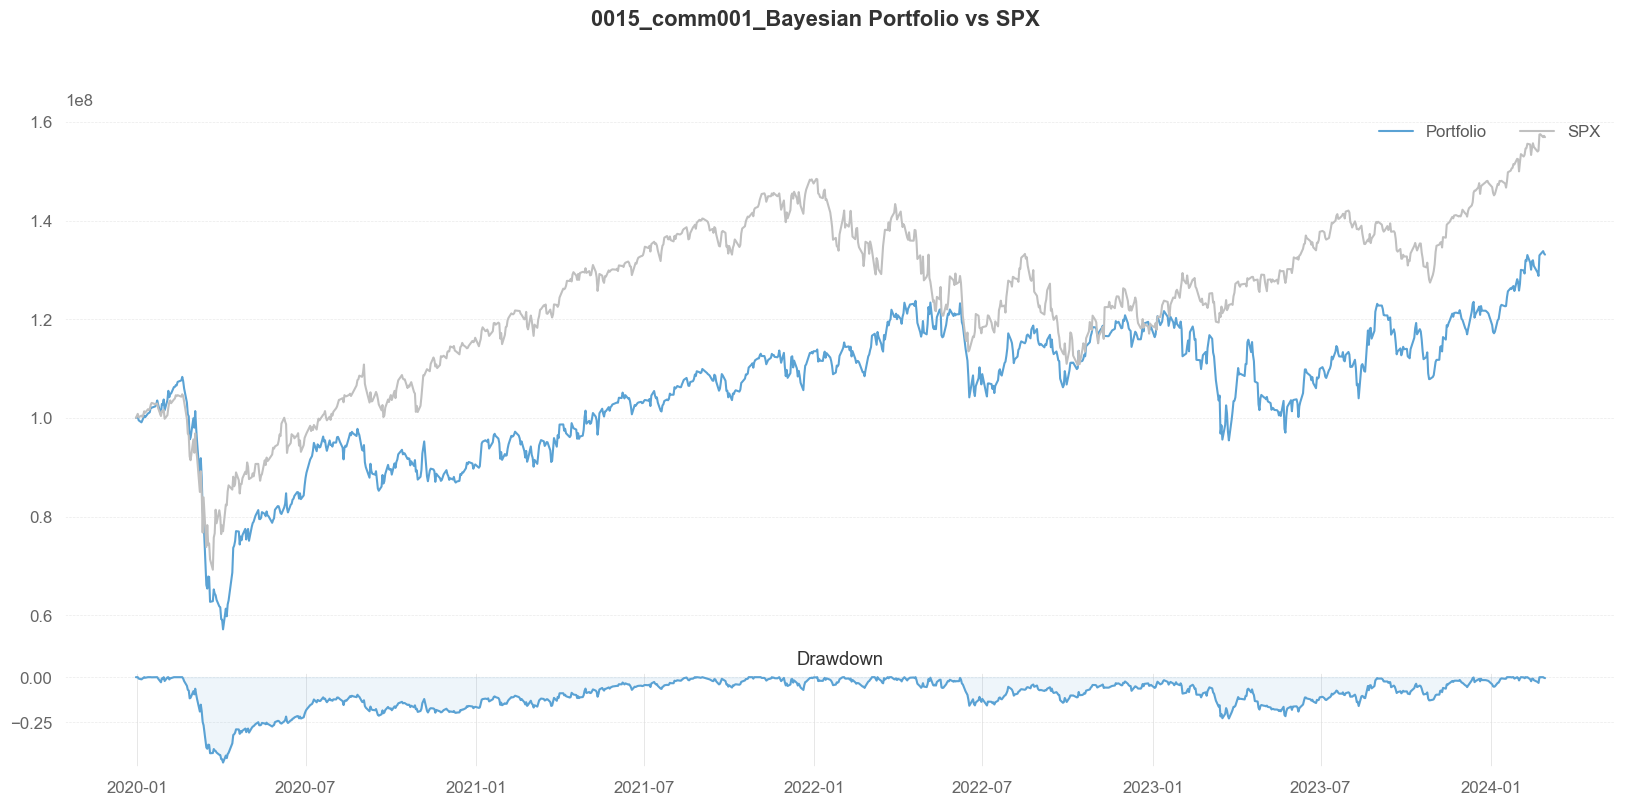

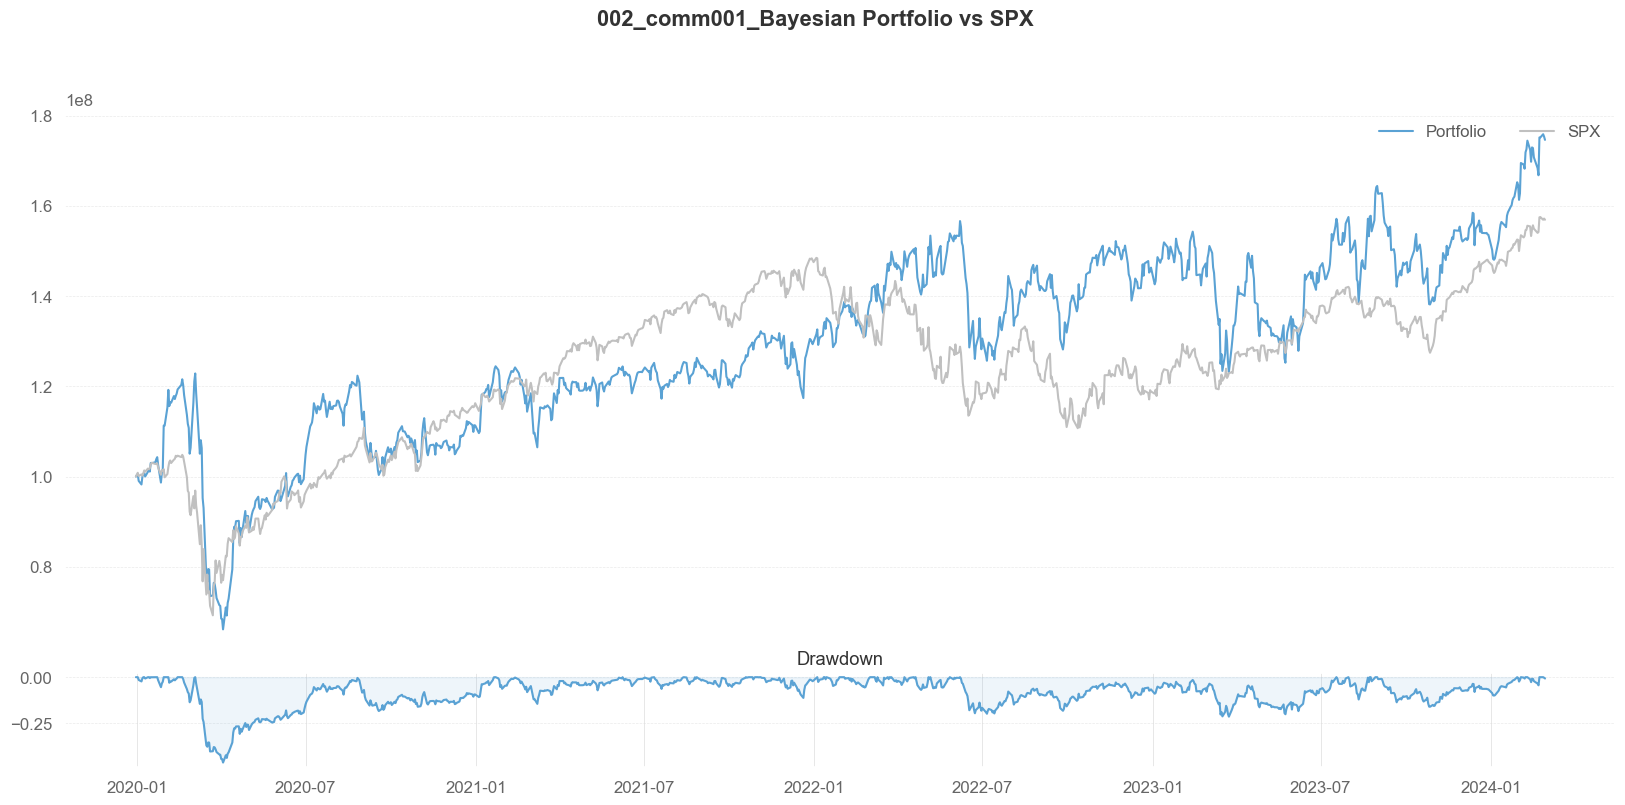

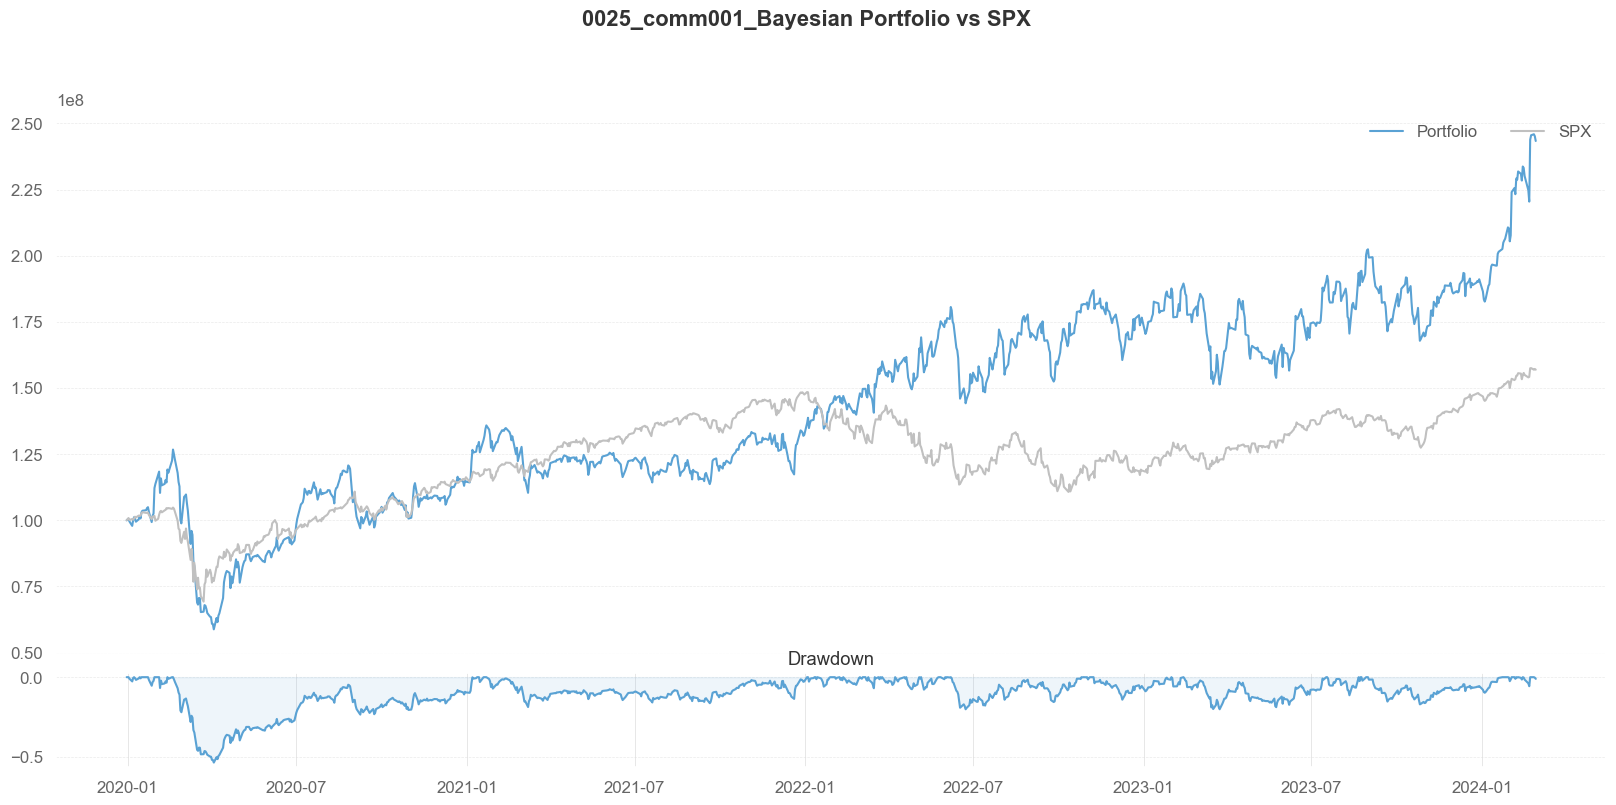

In [12]:
for i, target_return in enumerate(target_returns):
    dirname = "c:/software/Github_Repo/fina4380-project/src"
    # dirname = os.path.dirname(__file__)
    stock_list, combined_df, weights_df = LoadData(target_return, sheet_name, dirname)
    results = RunBacktest(stock_list, combined_df, weights_df, init_cash, comm_fee, False, False)
    returns, positions, transactions, gross_lev = results[0].analyzers.getbyname("pyfolio").get_pf_items()

    returns = returns.squeeze()
    returns.index = pd.to_datetime(returns.index, format='%Y-%m-%d')
    spx_prices = pd.read_excel(
        f'{dirname}/../data/SPX Daily Closing Price 14-24.xlsx', index_col=0)
    spx_prices.index = pd.to_datetime(spx_prices.index, format='%Y-%m-%d')
    port_prices = (1 + returns).cumprod() * init_cash

    # align the date of price and returns
    returns.index = returns.index.to_period('D')
    spx_prices.index = spx_prices.index.to_period('D')
    spx_prices = spx_prices.reindex(returns.index, method='ffill')
    spx_prices.index = spx_prices.index.to_timestamp()
    returns.index = returns.index.to_timestamp()
    spx_prices = spx_prices / spx_prices.iloc[0] * init_cash

    PortReport(returns, port_prices, spx_prices, target_return, comm, sheet_name, dirname)